In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Library for plotting candles
# pip install mplfinance
import mplfinance as mpf 
# https://github.com/matplotlib/mplfinance/blob/master/examples/using_lines.ipynb

# from trendlines import check_trend_line

from trendlines import fit_trendlines_single
from trendlines import mapear_retas_com_bottoms
from trendlines import mapear_retas_com_tops
from trendlines import identifica_retas_similares_suporte
from trendlines import identifica_retas_similares_resistencia
from tops_e_bottoms import checa_tops
from tops_e_bottoms import checa_bottoms
from calcula_RSI import compute_rsi

# Carregando os dados
data = pd.read_csv('dados_input/BTCUSDT86400.csv', parse_dates=['date'])
data = data.set_index('date')

# Take natural log of data to resolve price scaling issues
data_log = np.log(data)


# Cálculo do RSI

In [31]:

janela_rsi = 35
data['RSI'] = compute_rsi(data_log['close'],janela_rsi)
rsi_values = compute_rsi(data_log['close'], janela_rsi)

close_df = pd.DataFrame(data_log['close'])
close_df.to_csv('log_close.csv', index=True)

close_df = pd.DataFrame(data['close'])
close_df.to_csv('close.csv', index=True)

rsi_df = pd.DataFrame(data['RSI'])
rsi_df.to_csv('dados_csv_produzidos/rsi_values.csv', index=True)


date
2018-01-02         NaN
2018-01-03         NaN
2018-01-04         NaN
2018-01-05         NaN
2018-01-06         NaN
                ...   
2022-12-27    0.005323
2022-12-28    0.005596
2022-12-29    0.005589
2022-12-30    0.005501
2022-12-31    0.005503
Name: close, Length: 1825, dtype: float64
date
2018-01-02         NaN
2018-01-03         NaN
2018-01-04         NaN
2018-01-05         NaN
2018-01-06         NaN
                ...   
2022-12-27    0.005323
2022-12-28    0.005596
2022-12-29    0.005589
2022-12-30    0.005501
2022-12-31    0.005503
Name: close, Length: 1825, dtype: float64


Encontrando Topos e Fundos do RSI

c:\Users\User\Dropbox\FGV\Curso Estratégias de Trading\Lista 2\tops_e_bottoms.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  v = data[k]
c:\Users\User\Dropbox\FGV\Curso Estratégias de Trading\Lista 2\tops_e_bottoms.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if data[k + i] > v or data[k - i] > v:
C:\Users\User\AppData\Local\Temp\ipykernel_23344\886893384.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  top = [i, i 

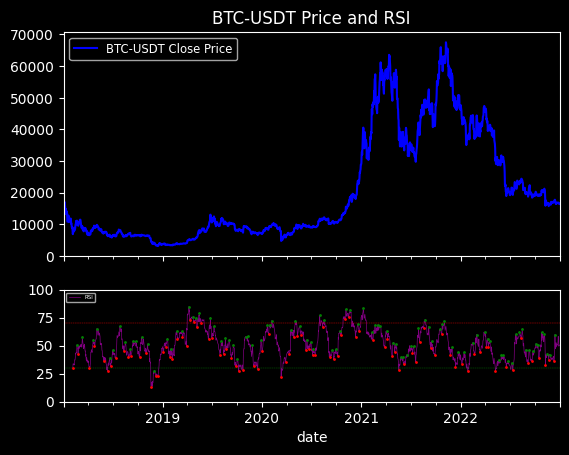

In [32]:
tops = []
bottoms = []
ordem = 6
for i in range(len(data['RSI'])):
    if checa_tops(data['RSI'], i, ordem):
        # top[0] = confirmation index
        # top[1] = index of top
        # top[2] = price of top
        top = [i, i - ordem, data['RSI'][i - ordem]]
        tops.append(top)
    
    if checa_bottoms(data['RSI'], i, ordem):
        # bottom[0] = confirmation index
        # bottom[1] = index of bottom
        # bottom[2] = price of bottom
        bottom = [i, i - ordem, data['RSI'][i - ordem]]
        bottoms.append(bottom)

tops_df = pd.DataFrame(tops, columns=['conf_idx', 'top_idx', 'top_price'])
tops_df = tops_df.dropna(subset=['top_price'])
tops_df.to_csv('dados_csv_produzidos/topos.csv', index=True)

bottoms_df = pd.DataFrame(bottoms, columns=['conf_idx', 'bottom_idx', 'bottom_price'])
bottoms_df = bottoms_df.dropna(subset=['bottom_price'])
bottoms_df.to_csv('dados_csv_produzidos/bottoms.csv', index=True)

idx = data.index

plt.style.use('dark_background')
fig, (ax1, ax3) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Plotando o preço de fechamento
data['close'].plot(ax=ax1, color='blue', label='BTC-USDT Close Price')

# Plotando o RSI
data['RSI'].plot(ax=ax3, color='purple', label='RSI', linewidth = 0.5)
ax3.axhline(70, color='red', linestyle='--', linewidth = 0.3)  # Linha de sobrecompra
ax3.axhline(30, color='green', linestyle='--', linewidth = 0.3)  # Linha de sobrevenda

plt.legend()
ax1.set_title("BTC-USDT Price and RSI")
ax1.legend(loc='upper left', fontsize='small')
ax3.legend(loc='upper left', fontsize=4)
ax3.set_ylim([0, 100])  # O RSI varia de 0 a 100

# Plotar os topos e fundos no gráfico
for top in tops_df.itertuples():
    # Plotar cada topo no gráfico RSI usando a data correspondente
    ax3.plot(idx[top.top_idx], data['RSI'][top.top_idx], marker='o', color='green', markersize=1)

for bottom in bottoms_df.itertuples():
    # Plotar cada fundo no gráfico RSI usando a data correspondente
    ax3.plot(idx[bottom.bottom_idx], data['RSI'][bottom.bottom_idx], marker='o', color='red', markersize=1)


fig.savefig('meu_grafico_0.png', dpi=300)  # Salva a figura como um arquivo PNG com alta resolução

plt.show()

Escolhendo as janelas de observação para a construção das retas de suporte

In [33]:

# Parâmetro
lookback = 200
contador_janela = 0
borda_esquerda = bottoms_df['bottom_idx'].iloc[contador_janela]

# Inicializar DataFrames
support_slope = [np.nan] * len(rsi_values)
colunas_suporte = ['indice', 'indice_original_lower_pivot', 'valor_rsi', 'support_slope', 'support_intercept', 'inicio_janela', 'fim_janela']
trendlines_suporte_df = pd.DataFrame(columns=colunas_suporte)

while borda_esquerda + lookback < len(rsi_values):
    # Chamar a função fit_trendlines_single para a janela sendo avaliada
    lower_pivot, support_slope, upper_pivot, resist_slope = fit_trendlines_single(rsi_values[borda_esquerda:borda_esquerda+lookback - 1])
    lower_pivot = lower_pivot + borda_esquerda
    valor_rsi = data['RSI'].iloc[lower_pivot]
    suport_intercept = data['RSI'].iloc[lower_pivot] - lower_pivot * support_slope
    nova_linha_suporte = {
        'indice': contador_janela,
        'indice_original_lower_pivot': lower_pivot,
        'valor_rsi': valor_rsi,
        'support_slope': support_slope,
        'support_intercept':suport_intercept,
        'inicio_janela': borda_esquerda,
        'fim_janela':borda_esquerda + lookback - 1
    }
    trendlines_suporte_df = trendlines_suporte_df._append(nova_linha_suporte, ignore_index=True)

    try:
        proximo_esquerda = bottoms_df.loc[bottoms_df['bottom_idx'].gt(borda_esquerda), 'bottom_idx'].min()
        rolagem_1 = proximo_esquerda - borda_esquerda
    except IndexError:
        proximo_esquerda = None  # Ou qualquer valor padrão que você queira usar

    try:
        proximo_direita = bottoms_df.loc[bottoms_df['bottom_idx'].gt(borda_esquerda+lookback), 'bottom_idx'].min()
        rolagem_2 = proximo_direita - (borda_esquerda + lookback)
    except IndexError:
        proximo_direita = None  # Ou qualquer valor padrão que você queira usar

    if proximo_esquerda == None:
        if proximo_direita == None:
            break
        else:
            rolagem = rolagem_2
    else:
        if proximo_direita == None:
            rolagem = rolagem_1
        else:
            rolagem = min(rolagem_1,rolagem_2)
    contador_janela += 1
    borda_esquerda = borda_esquerda + rolagem
    
trendlines_suporte_df.to_csv('dados_csv_produzidos/trendlines_suporte.csv', index=True)


C:\Users\User\AppData\Local\Temp\ipykernel_23344\990998257.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  trendlines_suporte_df = trendlines_suporte_df._append(nova_linha_suporte, ignore_index=True)


Criando as linhas de resistência

In [34]:
contador_janela = 0
borda_esquerda = tops_df['top_idx'].iloc[contador_janela]

# Inicializar DataFrames

resist_slope = [np.nan] * len(rsi_values)
colunas_resistencia = ['indice', 'indice_original_upper_pivot','valor_rsi', 'resist_slope', 'resist_intercept', 'inicio_janela', 'fim_janela']
trendlines_resistencia_df = pd.DataFrame(columns=colunas_resistencia)

while borda_esquerda + lookback < len(rsi_values):
    # Chamar a função fit_trendlines_single para a janela sendo avaliada
    lower_pivot, support_slope, upper_pivot, resist_slope = fit_trendlines_single(rsi_values[borda_esquerda:borda_esquerda+lookback - 1])
    upper_pivot = upper_pivot + borda_esquerda
    valor_rsi = data['RSI'].iloc[upper_pivot]
    resist_intercept = data['RSI'].iloc[upper_pivot] - upper_pivot * resist_slope
    nova_linha_resistencia = {
        'indice': contador_janela,
        'indice_original_upper_pivot': upper_pivot,
        'valor_rsi': valor_rsi,
        'resist_slope': resist_slope,
        'resist_intercept':resist_intercept,
        'inicio_janela': borda_esquerda,
        'fim_janela':borda_esquerda + lookback - 1
    }
    trendlines_resistencia_df = trendlines_resistencia_df._append(nova_linha_resistencia, ignore_index=True)

    try:
        proximo_esquerda = tops_df.loc[tops_df['top_idx'].gt(borda_esquerda), 'top_idx'].min()
        rolagem_1 = proximo_esquerda - borda_esquerda
    except IndexError:
        proximo_esquerda = None  # Ou qualquer valor padrão que você queira usar

    try:
        proximo_direita = tops_df.loc[tops_df['top_idx'].gt(borda_esquerda+lookback), 'top_idx'].min()
        rolagem_2 = proximo_direita - (borda_esquerda + lookback)
    except IndexError:
        proximo_direita = None  # Ou qualquer valor padrão que você queira usar

    if proximo_esquerda == None:
        if proximo_direita == None:
            break
        else:
            rolagem = rolagem_2
    else:
        if proximo_direita == None:
            rolagem = rolagem_1
        else:
            rolagem = min(rolagem_1,rolagem_2)
    contador_janela += 1
    borda_esquerda = borda_esquerda + rolagem
    
trendlines_resistencia_df.to_csv('dados_csv_produzidos/trendlines_resistencia.csv', index=True)

C:\Users\User\AppData\Local\Temp\ipykernel_23344\4049671785.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  trendlines_resistencia_df = trendlines_resistencia_df._append(nova_linha_resistencia, ignore_index=True)


In [35]:
slope_ok_trendlines_suporte_df = trendlines_suporte_df.loc[trendlines_suporte_df['support_slope'] > 0]
slope_ok_trendlines_suporte_df = slope_ok_trendlines_suporte_df.reset_index(drop=True)
slope_ok_trendlines_suporte_df.to_csv('dados_csv_produzidos/slope_ok_trendlines_suporte.csv', index=True)

slope_ok_trendlines_resistencia_df = trendlines_resistencia_df.loc[trendlines_resistencia_df['resist_slope'] < 0]
slope_ok_trendlines_resistencia_df = slope_ok_trendlines_resistencia_df.reset_index(drop=True)
slope_ok_trendlines_resistencia_df.to_csv('dados_csv_produzidos/slope_ok_trendlines_resistencia.csv', index=True)

Plotando meu_grafico_1 com o primeiro ajuste

C:\Users\User\AppData\Local\Temp\ipykernel_23344\3750176219.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax3.plot(idx[top.top_idx], data['RSI'][top.top_idx], marker='o', color='green', markersize=0.3)
C:\Users\User\AppData\Local\Temp\ipykernel_23344\3750176219.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax3.plot(idx[bottom.bottom_idx], data['RSI'][bottom.bottom_idx], marker='o', color='red', markersize=0.3)


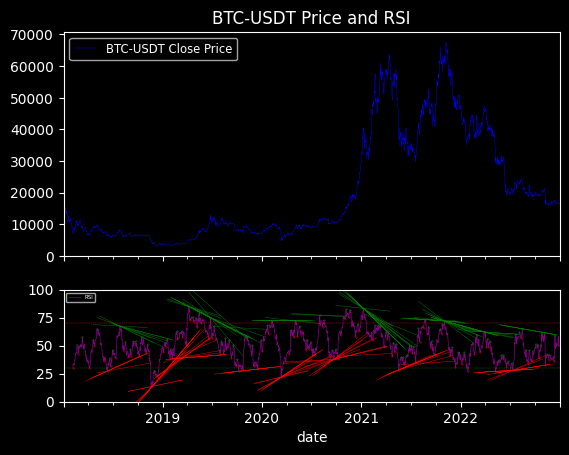

In [36]:
plt.style.use('dark_background')
fig, (ax1, ax3) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# ----------------------------------------------------------------   
# Plotando o preço de fechamento
# ----------------------------------------------------------------   

data['close'].plot(ax=ax1, color='blue', label='BTC-USDT Close Price', linewidth = 0.3)

# ----------------------------------------------------------------   
# Plotando o RSI
# ----------------------------------------------------------------   

data['RSI'].plot(ax=ax3, color='purple', label='RSI', linewidth = 0.5)
ax3.axhline(70, color='red', linestyle='--', linewidth = 0.3)  # Linha de sobrecompra
ax3.axhline(30, color='green', linestyle='--', linewidth = 0.3)  # Linha de sobrevenda

plt.legend()
ax1.set_title("BTC-USDT Price and RSI")
ax1.legend(loc='upper left', fontsize='small')
ax3.legend(loc='upper left', fontsize=4)
ax3.set_ylim([0, 100])  # O RSI varia de 0 a 100

# ----------------------------------------------------------------   
# Plotar os topos e fundos no gráfico
# ----------------------------------------------------------------   

for top in tops_df.itertuples():
    # Plotar cada topo no gráfico RSI usando a data correspondente
    ax3.plot(idx[top.top_idx], data['RSI'][top.top_idx], marker='o', color='green', markersize=0.3)

for bottom in bottoms_df.itertuples():
    # Plotar cada fundo no gráfico RSI usando a data correspondente
    ax3.plot(idx[bottom.bottom_idx], data['RSI'][bottom.bottom_idx], marker='o', color='red', markersize=0.3)


# Obter as datas associadas aos valores do RSI
datas = data.index[len(data.index) - len(rsi_values):]

# ----------------------------------------------------------------   
# Plotar as retas de suporte do RSI
# ----------------------------------------------------------------   

for i in range(len(slope_ok_trendlines_suporte_df)):
    row = slope_ok_trendlines_suporte_df.iloc[i]

    x_start = int(row['inicio_janela'])
    y_start = row['support_slope'] * x_start + row['support_intercept']

    # Ajustar y_start se necessário
    if y_start < 0:
        x_start = max(0, min(len(datas) - 1, int(-row['support_intercept'] / row['support_slope'])))
        y_start = row['support_slope'] * x_start + row['support_intercept']

    x_end = int(row['fim_janela'])
    y_end = row['support_slope'] * x_end + row['support_intercept']

    # Ajustar y_end se necessário
    if y_end < 0:
        x_end = max(0, min(len(datas) - 1, int(-row['support_intercept'] / row['support_slope'])))
        y_end = row['support_slope'] * x_end + row['support_intercept']

    # Obter datas de início e fim
    data_start = datas[x_start]
    data_end = datas[x_end]

    # Desenhar o segmento de reta
    ax3.plot([data_start, data_end], [y_start, y_end], color='r', linewidth=0.3)

# ----------------------------------------------------------------


# Obter as datas associadas aos valores do RSI
datas = data.index[len(data.index) - len(rsi_values):]

# ----------------------------------------------------------------   
# Plotar as retas de resistencia do RSI
# ----------------------------------------------------------------   

for i in range(len(slope_ok_trendlines_resistencia_df)):
    row = slope_ok_trendlines_resistencia_df.iloc[i]

    x_start = int(row['inicio_janela'])
    y_start = row['resist_slope'] * x_start + row['resist_intercept']

    # Ajustar y_start se necessário
    if y_start < 0:
        x_start = max(0, min(len(datas) - 1, int(-row['resist_intercept'] / row['resist_slope'])))
        y_start = row['resist_slope'] * x_start + row['resist_intercept']

    x_end = int(row['fim_janela'])
    y_end = row['resist_slope'] * x_end + row['resist_intercept']

    # Ajustar y_end se necessário
    if y_end < 0:
        x_end = max(0, min(len(datas) - 1, int(-row['resist_intercept'] / row['resist_slope'])))
        y_end = row['resist_slope'] * x_end + row['resist_intercept']

    # Obter datas de início e fim
    data_start = datas[x_start]
    data_end = datas[x_end]

    # Desenhar o segmento de reta
    ax3.plot([data_start, data_end], [y_start, y_end], color='green', linewidth=0.3)

# ----------------------------------------------------------------

fig.savefig('meu_grafico_1.png', dpi=300)  # Salva a figura como um arquivo PNG com alta resolução

plt.show()

# ----------------------------------------------------------------



Mapeando as retas suporte para encontrar as que passaram por três bottoms até o fim da janela que criou a reta

In [37]:
mapeados_trendlines_suporte_df = mapear_retas_com_bottoms(bottoms_df, slope_ok_trendlines_suporte_df, 2)

mapeados_trendlines_suporte_df.to_csv('dados_csv_produzidos/mapeados_trendlines_suporte.csv', index=True)

In [38]:
# Preparando o DataFrame para os resultados consolidados


mapeados_trendlines_suporte_df.to_csv('dados_csv_produzidos/mapeados_trendlines_suporte.csv', index=True)

expurgado_trendlines_suporte_df = mapeados_trendlines_suporte_df[mapeados_trendlines_suporte_df['mapeado'] != 0]

expurgado_trendlines_suporte_df.to_csv('dados_csv_produzidos/expurgado_trendlines_suporte.csv', index=True)

# Preparando o DataFrame para os resultados consolidados
mapeados_trendlines_resistencia_df = mapear_retas_com_tops(tops_df, slope_ok_trendlines_resistencia_df, 2)

mapeados_trendlines_resistencia_df.to_csv('dados_csv_produzidos/mapeados_trendlines_resistencia.csv', index=True)

expurgado_trendlines_resistencia_df = mapeados_trendlines_resistencia_df[mapeados_trendlines_resistencia_df['mapeado'] != 0]

expurgado_trendlines_resistencia_df.to_csv('dados_csv_produzidos/expurgado_trendlines_resistencia.csv', index=True)

C:\Users\User\AppData\Local\Temp\ipykernel_23344\160506735.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax3.plot(idx[top.top_idx], data['RSI'][top.top_idx], marker='o', color='green', markersize=0.3)
C:\Users\User\AppData\Local\Temp\ipykernel_23344\160506735.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax3.plot(idx[bottom.bottom_idx], data['RSI'][bottom.bottom_idx], marker='o', color='red', markersize=0.3)


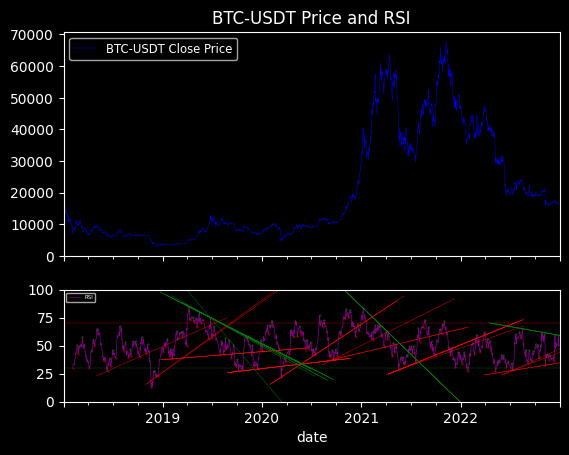

In [43]:
plt.style.use('dark_background')
fig, (ax1, ax3) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# ----------------------------------------------------------------   
# Plotando o preço de fechamento
# ----------------------------------------------------------------   

data['close'].plot(ax=ax1, color='blue', label='BTC-USDT Close Price', linewidth = 0.3)

# ----------------------------------------------------------------   
# Plotando o RSI
# ----------------------------------------------------------------   

data['RSI'].plot(ax=ax3, color='purple', label='RSI', linewidth = 0.5)
ax3.axhline(70, color='red', linestyle='--', linewidth = 0.3)  # Linha de sobrecompra
ax3.axhline(30, color='green', linestyle='--', linewidth = 0.3)  # Linha de sobrevenda

plt.legend()
ax1.set_title("BTC-USDT Price and RSI")
ax1.legend(loc='upper left', fontsize='small')
ax3.legend(loc='upper left', fontsize=4)
ax3.set_ylim([0, 100])  # O RSI varia de 0 a 100

# ----------------------------------------------------------------   
# Plotar os topos e fundos no gráfico
# ----------------------------------------------------------------   

for top in tops_df.itertuples():
    # Plotar cada topo no gráfico RSI usando a data correspondente
    ax3.plot(idx[top.top_idx], data['RSI'][top.top_idx], marker='o', color='green', markersize=0.3)

for bottom in bottoms_df.itertuples():
    # Plotar cada fundo no gráfico RSI usando a data correspondente
    ax3.plot(idx[bottom.bottom_idx], data['RSI'][bottom.bottom_idx], marker='o', color='red', markersize=0.3)
    
# Obter as datas associadas aos valores do RSI
datas = data.index[len(data.index) - len(rsi_values):]

# ----------------------------------------------------------------   
# Plotar as retas de suporte do RSI
# ----------------------------------------------------------------   

for i in range(len(expurgado_trendlines_suporte_df)):
    row = expurgado_trendlines_suporte_df.iloc[i]

    x_start = int(row['inicio_janela'])-40
    y_start = row['support_slope'] * x_start + row['support_intercept']

    # Ajustar y_start se necessário
    if y_start < 0:
        x_start = max(0, min(len(datas) - 1, int(-row['support_intercept'] / row['support_slope'])))
        y_start = row['support_slope'] * x_start + row['support_intercept']

    x_end = min(len(datas)-1, 300+int(row['x_max']))
    y_end = row['support_slope'] * x_end + row['support_intercept']

    # Ajustar y_end se necessário
    if y_end < 0:
        x_end = max(0, min(len(datas) - 1, int(-row['support_intercept'] / row['support_slope'])))
        y_end = row['support_slope'] * x_end + row['support_intercept']

    # Obter datas de início e fim
    data_start = datas[x_start]
    data_end = datas[x_end]

    # Desenhar o segmento de reta
    ax3.plot([data_start, data_end], [y_start, y_end], color='r', linewidth=0.3)

# ----------------------------------------------------------------

for i in range(len(expurgado_trendlines_resistencia_df)):
    row = expurgado_trendlines_resistencia_df.iloc[i]

    x_start = int(row['inicio_janela'])-40
    y_start = row['resist_slope'] * x_start + row['resist_intercept']

    # Ajustar y_start se necessário
    if y_start < 0:
        x_start = max(0, min(len(datas) - 1, int(-row['resist_intercept'] / row['resist_slope'])))
        y_start = row['resist_slope'] * x_start + row['resist_intercept']

    x_end = min(len(datas)-1, 300+int(row['fim_janela']))
    y_end = row['resist_slope'] * x_end + row['resist_intercept']

    # Ajustar y_end se necessário
    if y_end < 0:
        x_end = max(0, min(len(datas) - 1, 200+int(-row['resist_intercept'] / row['resist_slope'])))
        y_end = row['resist_slope'] * x_end + row['resist_intercept']

    # Obter datas de início e fim
    data_start = datas[x_start]
    data_end = datas[x_end]

    # Desenhar o segmento de reta
    ax3.plot([data_start, data_end], [y_start, y_end], color='green', linewidth=0.3)

# ----------------------------------------------------------------

fig.savefig('meu_grafico_2.png', dpi=300)  # Salva a figura como um arquivo PNG com alta resolução

plt.show()

# ----------------------------------------------------------------

In [40]:
eliminado_trendlines_suporte_df = identifica_retas_similares_suporte(expurgado_trendlines_suporte_df)
eliminado_trendlines_suporte_df.to_csv('dados_csv_produzidos/eliminado_trendlines_suporte.csv', index=True)

eliminado_trendlines_resistencia_df = identifica_retas_similares_resistencia(expurgado_trendlines_resistencia_df)
eliminado_trendlines_resistencia_df.to_csv('dados_csv_produzidos/eliminado_trendlines_resistencia.csv', index=True)

C:\Users\User\AppData\Local\Temp\ipykernel_23344\253449207.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax3.plot(idx[top.top_idx], data['RSI'][top.top_idx], marker='o', color='green', markersize=0.3)
C:\Users\User\AppData\Local\Temp\ipykernel_23344\253449207.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax3.plot(idx[bottom.bottom_idx], data['RSI'][bottom.bottom_idx], marker='o', color='red', markersize=0.3)


NameError: name 'eliminado_trendlines_suporte_df' is not defined

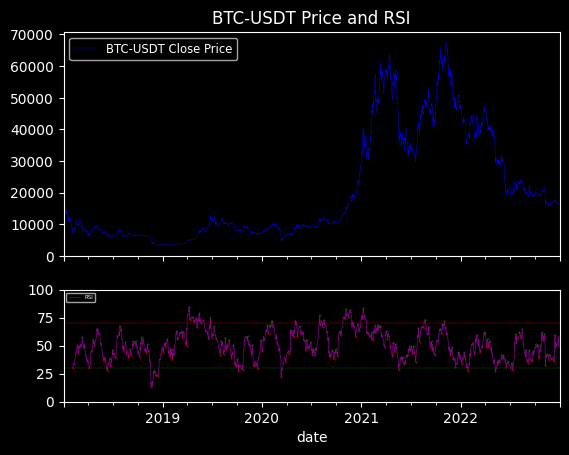

In [41]:

plt.style.use('dark_background')
fig, (ax1, ax3) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# ----------------------------------------------------------------   
# Plotando o preço de fechamento
# ----------------------------------------------------------------   

data['close'].plot(ax=ax1, color='blue', label='BTC-USDT Close Price', linewidth = 0.3)

# ----------------------------------------------------------------   
# Plotando o RSI
# ----------------------------------------------------------------   

data['RSI'].plot(ax=ax3, color='purple', label='RSI', linewidth = 0.5)
ax3.axhline(70, color='red', linestyle='--', linewidth = 0.3)  # Linha de sobrecompra
ax3.axhline(30, color='green', linestyle='--', linewidth = 0.3)  # Linha de sobrevenda

plt.legend()
ax1.set_title("BTC-USDT Price and RSI")
ax1.legend(loc='upper left', fontsize='small')
ax3.legend(loc='upper left', fontsize=4)
ax3.set_ylim([0, 100])  # O RSI varia de 0 a 100

# ----------------------------------------------------------------   
# Plotar os topos e fundos no gráfico
# ----------------------------------------------------------------   

for top in tops_df.itertuples():
    # Plotar cada topo no gráfico RSI usando a data correspondente
    ax3.plot(idx[top.top_idx], data['RSI'][top.top_idx], marker='o', color='green', markersize=0.3)

for bottom in bottoms_df.itertuples():
    # Plotar cada fundo no gráfico RSI usando a data correspondente
    ax3.plot(idx[bottom.bottom_idx], data['RSI'][bottom.bottom_idx], marker='o', color='red', markersize=0.3)
    
# Obter as datas associadas aos valores do RSI
datas = data.index[len(data.index) - len(rsi_values):]

# ----------------------------------------------------------------   
# Plotar as retas de suporte do RSI
# ----------------------------------------------------------------   

for i in range(len(eliminado_trendlines_suporte_df)):
    row = eliminado_trendlines_suporte_df.iloc[i]

    x_start = int(row['x_min'])-40
    y_start = row['support_slope'] * x_start + row['support_intercept']

    # Ajustar y_start se necessário
    if y_start < 0:
        x_start = max(0, min(len(datas) - 1, int(-row['support_intercept'] / row['support_slope'])))
        y_start = row['support_slope'] * x_start + row['support_intercept']

    x_end = min(len(datas)-1, 300+int(row['x_max']))
    y_end = row['support_slope'] * x_end + row['support_intercept']

    # Ajustar y_end se necessário
    if y_end < 0:
        x_end = max(0, min(len(datas) - 1, int(-row['support_intercept'] / row['support_slope'])))
        y_end = row['support_slope'] * x_end + row['support_intercept']

    # Obter datas de início e fim
    data_start = datas[x_start]
    data_end = datas[x_end]

    # Desenhar o segmento de reta
    ax3.plot([data_start, data_end], [y_start, y_end], color='r', linewidth=0.3)

# ----------------------------------------------------------------

for i in range(len(eliminado_trendlines_resistencia_df)):
    row = eliminado_trendlines_resistencia_df.iloc[i]

    x_start = int(row['x_min'])
    y_start = row['resist_slope'] * x_start + row['resist_intercept']

    # Ajustar y_start se necessário
    if y_start < 0:
        x_start = max(0, min(len(datas) - 1, int(-row['resist_intercept'] / row['resist_slope'])))
        y_start = row['resist_slope'] * x_start + row['resist_intercept']

    x_end = min(len(datas)-1, 300+int(row['x_max']))
    y_end = row['resist_slope'] * x_end + row['resist_intercept']

    # Ajustar y_end se necessário
    if y_end < 0:
        x_end = max(0, min(len(datas) - 1, int(-row['resist_intercept'] / row['resist_slope'])))
        y_end = row['resist_slope'] * x_end + row['resist_intercept']

    # Obter datas de início e fim
    data_start = datas[x_start]
    data_end = datas[x_end]

    # Desenhar o segmento de reta
    ax3.plot([data_start, data_end], [y_start, y_end], color='green', linewidth=0.3)

# ----------------------------------------------------------------
fig.savefig('meu_grafico_3.png', dpi=300)  # Salva a figura como um arquivo PNG com alta resolução

plt.show()

# ----------------------------------------------------------------
